In [474]:
import numpy
import matplotlib.pyplot as plt

import seeldlm
from seeldlm.utils import rand_obs, rand_nnd, random_nan
from dataload import weather_dataframe

In [475]:
weather_dataframe()

,year,month,day,humidity(%),TEMPCORR,speed(m/sec),O3#AGP(μg/m3),NO2AGP (μg/m3),NO#AGP(μg/m3),O3#ATH(μg/m3),NO2ATH(μg/m3),NO#ATH(μg/m3),CO#ATH(mg/m3),SO2ATH(μg/m3),O3PIR(μg/m3),NO2PIR(μg/m3),NO#PIR(μg/m3),CO#PIR(mg/m3),SO2PIR(μg/m3),DATE
1,2001,1,1,82.00,10.93,2.70,66.83,9.38,1.08,20.75,52.79,25.50,1.71,3.50,20.55,51.71,39.13,1.61,8.29,01/01/2001
2,2001,1,2,72.00,11.12,2.10,46.75,13.58,1.79,11.54,59.04,104.96,2.85,17.17,20.64,56.67,76.54,2.15,23.54,02/01/2001
3,2001,1,3,73.00,12.11,2.30,49.46,26.17,4.58,10.08,73.54,215.17,4.80,23.29,20.72,78.54,151.38,3.23,32.75,03/01/2001
4,2001,1,4,73.00,12.81,1.90,67.08,20.67,3.17,7.21,95.42,342.46,7.25,25.67,20.81,92.54,183.00,4.23,35.50,04/01/2001
5,2001,1,5,81.00,12.18,1.60,51.71,19.38,3.83,3.04,95.08,253.08,6.67,23.08,20.90,87.75,180.50,4.15,33.83,05/01/2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2008,12,27,88.00,7.16,6.90,41.21,13.54,1.00,13.21,43.33,38.50,1.45,5.13,15.96,52.46,51.88,0.88,7.83,27/12/2008
2919,2008,12,28,83.00,5.93,6.60,36.83,14.08,1.00,14.46,40.25,38.13,1.48,5.29,22.88,44.46,36.54,0.64,8.54,28/12/2008
2920,2008,12,29,73.00,6.14,5.40,42.38,16.46,1.00,12.33,55.13,50.17,1.84,6.71,16.42,64.13,66.83,1.03,14.71,29/12/2008
2921,2008,12,30,65.00,4.66,6.90,49.83,13.33,1.13,19.67,53.00,42.46,1.66,6.63,27.54,62.46,58.00,0.97,11.33,30/12/2008


In [476]:
dataset = weather_dataframe()

data_array = dataset[["humidity(%)", "TEMPCORR"]].to_numpy(dtype=float)

# data_array = random_nan(data_array[0:3], 3)

# data_array[numpy.array([0,1,2])]

In [477]:
from typing import List
from random import normalvariate

data_array = numpy.expand_dims(numpy.random.uniform(size=75), axis=1)

def create_brownian_motion(size: "int"):

    data_list: "List[float]" = list()
    data_list.append(0)

    for _ in range(size-1):
        new_entry = data_list[-1] + normalvariate(0,3)
        data_list.append(new_entry)

    return data_list

data_array = numpy.expand_dims(numpy.array(create_brownian_motion(75)), axis=1)


In [478]:
# Model's observable period
PERIOD = 50

# Model's predicted period
BEYOND_PERIOD = 25


# Dimensional parameters
N = 1
M = data_array.shape[1]

In [479]:
factory = seeldlm.ComponentFactory()
model_compiler = seeldlm.ModelCompiler(M)

model_compiler.add_component_sequence(
    factory.polynomial(2),
    factory.harmonics(1,5),
    factory.form_free(5),
)
model_compiler.set_vertex(-1, 0, [0])
model_compiler.set_vertex(-1, 1, [0])
model_compiler.set_vertex(-1, 2, [0])

F = model_compiler.compile_transition()
H = model_compiler.compile_observation()

P: "int" = F.shape[0]

In [480]:
# Primordial model setting
n0 = rand_obs((P,N))
n0.covariance = rand_nnd(P, 1)

scale = rand_nnd(N, 1)
shape = N

er = seeldlm.InvWishartModel(scale, shape)

# Evolver setting
b_e = numpy.zeros((P, N)) # p by n
a_e = F # p by p
v_e = numpy.eye(P) * 1
te = seeldlm.TransitionModel(b_e, a_e, v_e)

# Predictor setting
b_p = numpy.zeros((M, N)) # m by n
a_p = H # m by p
v_p = numpy.eye(M) * 50
tp = seeldlm.TransitionModel(b_p, a_p, v_p)

In [481]:
evolvers = seeldlm.TransitionContainer(0,0)
evolvers.set_at_time(0, te)

observers = seeldlm.TransitionContainer(0,0)
observers.set_at_time(0,tp)


prime_memory = seeldlm.PrimeMemoryDLM(
    observed_period=PERIOD,
    predicted_period=BEYOND_PERIOD,
    primordial_model=n0,
    primordial_error=er,
    evolvers=evolvers,
    observers=observers,
    observations=data_array
)


model = seeldlm.ModellerDLM(prime_memory)

In [482]:
model.forward()
model.backward()
model.beyond()
new_memory = model.get_memory()

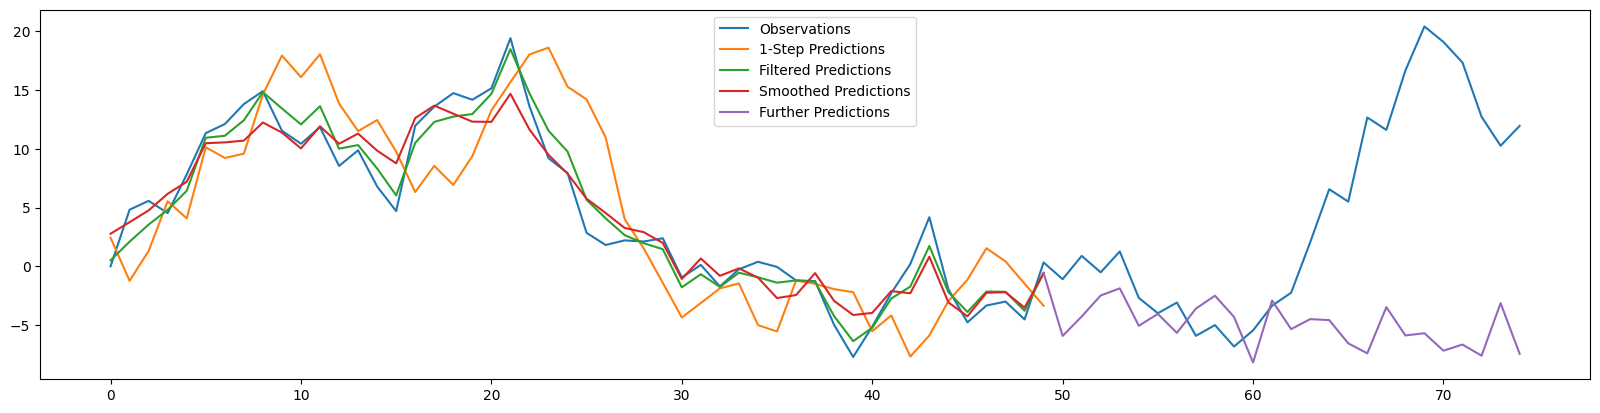

In [483]:
index=0

fig, ax = plt.subplots()

x0_data = list(range(len(data_array)))
x1_data = list(range(PERIOD))
x2_data = list(range(PERIOD-1, PERIOD + BEYOND_PERIOD))

y1_data = data_array[:,index]
y2_data = list(new_memory.evolved_spaces.mean(1,PERIOD,0,0))
y3_data = list(new_memory.filtered_spaces.mean(1,PERIOD,0,0))
y4_data = list(new_memory.smoothed_spaces.mean(1,PERIOD,0,0))
y5_data = list(new_memory.predicted_spaces.mean(PERIOD,PERIOD + BEYOND_PERIOD,0,0))

ax.plot(x0_data, y1_data, label="Observations")
ax.plot(x1_data, y2_data, label="1-Step Predictions")
ax.plot(x1_data, y3_data, label="Filtered Predictions")
ax.plot(x1_data, y4_data, label="Smoothed Predictions")
ax.plot(x2_data, y5_data, label="Further Predictions")

ax.legend()
fig.set_figwidth(20)
plt.show()

In [484]:

# nus = list(new_memory.wisharts.shape())[1:]
# lambdas = list(new_memory.wisharts.scale(0,0))[1:]
# tees = list(new_memory.wisharts.t_shape(0.05))[1:]
# sigmas = list(new_memory.smoothed_spaces.covariance(0,0))

# import math
# def deviation(t_value: "float", feature_covariance: "float", subject_covariance: "float", shape: "int") -> "float":
#     return t_value * math.sqrt(feature_covariance * subject_covariance / shape)

# deviations = [deviation(i, j, k, l) for i, j, k, l in zip(tees, sigmas, lambdas, nus)]
# yx2_data = [y+x for x, y in zip(deviations, y4_data)]
# xy2_data = [y-x for x, y in zip(deviations, y4_data)]
